In [448]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [449]:

import random
import numpy as np

# Set seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# For even more determinism (may slow down training)
tf.config.experimental.enable_op_determinism()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [450]:
train_data = pd.read_csv('data/train.csv')
valid_data = pd.read_csv('data/valid.csv')
test_data = pd.read_csv('data/test.csv')

In [451]:
# 2. Map string labels to integers (right after loading)
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
train_data['label'] = train_data['label'].map(label_map)
valid_data['label'] = valid_data['label'].map(label_map)
test_data['label']  = test_data['label'].map(label_map)

# (Optional but recommended) drop rows with unmapped or NaN labels
train_data = train_data.dropna()
valid_data = valid_data.dropna()
test_data  = test_data.dropna()


In [452]:
# Ambil teks dan label
train_texts, train_labels = train_data['text'], train_data['label']
valid_texts, valid_labels = valid_data['text'], valid_data['label']
test_texts,  test_labels  = test_data['text'],  test_data['label']

In [453]:
from tensorflow.keras.layers import TextVectorization

# Buat vectorizer berdasarkan training saja
vectorizer = TextVectorization(max_tokens=20000, output_mode="int", output_sequence_length=100)
vectorizer.adapt(train_texts)

In [454]:
# Siapkan dataset TensorFlow
batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((train_texts, train_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((valid_texts, valid_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((test_texts,  test_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [455]:
# Add this before training to check data types
print("Sample text:", train_texts.iloc[0])
print("Sample label:", train_labels.iloc[0], "Type:", type(train_labels.iloc[0]))

# Check the shape and first few elements of each dataset
print("\nFirst batch of train_ds:")
for text_batch, label_batch in train_ds.take(1):
    print("Text shape:", text_batch.shape)
    print("Label shape:", label_batch.shape)
    print("Label values:", label_batch.numpy())

Sample text: Nikmati cicilan 0% hingga 12 bulan untuk pemesanan tiket pesawat air asia dengan kartu kredit bni!
Sample label: 1 Type: <class 'numpy.int64'>

First batch of train_ds:
Text shape: (32,)
Label shape: (32,)
Label values: [1 2 1 2 2 1 1 0 0 2 2 0 0 2 2 2 1 1 1 0 1 2 2 0 1 0 0 0 0 2 2 1]


In [456]:
# Import required modules
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, SimpleRNN, Bidirectional, Dropout, Dense, Input


model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Embedding(input_dim=20000, output_dim=128, mask_zero=True),
    Bidirectional(SimpleRNN(64)),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

In [457]:
print(model.summary())

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_21           │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_21 (Embedding)        │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_21                │ (None, 128)            │        24,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,585,091 (9.86 MB)

 Trainable params: 2,585,091 (9.86 MB)

 Non-trainable params: 0 (0.00 B)

None


In [458]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [459]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(train_ds, validation_data=valid_ds, epochs=100, callbacks=[early_stopping])

# model.fit(train_ds, validation_data=valid_ds, epochs=100)


# Evaluasi akhir
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nAkurasi akhir pada test set: {test_acc:.4f}")

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.4217 - loss: 1.0480 - val_accuracy: 0.5100 - val_loss: 0.9953
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8681 - loss: 0.6760 - val_accuracy: 0.5100 - val_loss: 1.0112
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9690 - loss: 0.3723 - val_accuracy: 0.5400 - val_loss: 0.9046
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9818 - loss: 0.1778 - val_accuracy: 0.4800 - val_loss: 1.0455
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9928 - loss: 0.0978 - val_accuracy: 0.6400 - val_loss: 0.8403
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9979 - loss: 0.0401 - val_accuracy: 0.6200 - val_loss: 0.9208
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 1.0000 - loss: 0.0229 - val_accuracy: 0.6600 - val_loss: 0.9073
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 0

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

Macro F1-Score: 0.6315

Classification Report:
              precision    recall  f1-score   support

    Negative       0.57      0.67      0.61       153
     Neutral       0.58      0.44      0.50        96
    Positive       0.79      0.77      0.78       151

    accuracy                           0.65       400
   macro avg       0.65      0.63      0.63       400
weighted avg       0.65      0.65      0.65       400



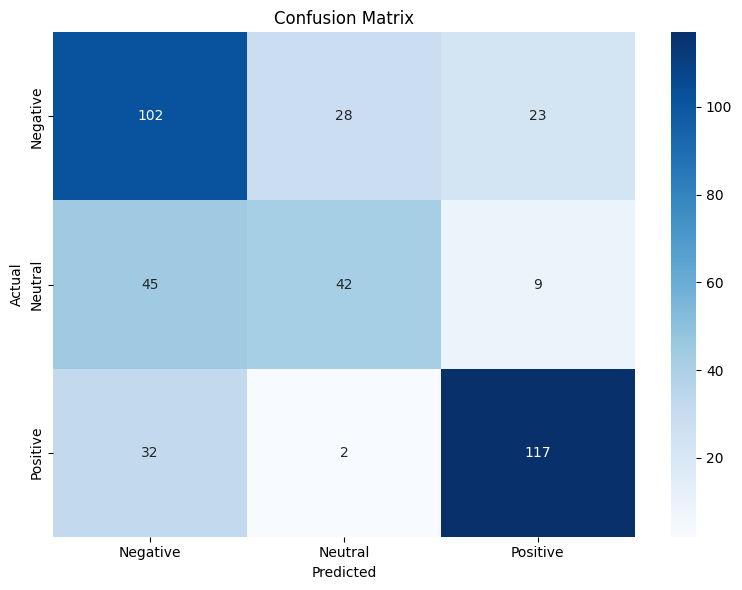

In [460]:
# Import necessary metrics
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on test set
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels from test dataset (need to extract from the TensorFlow dataset)
test_labels_list = []
for _, labels in test_ds:
    test_labels_list.append(labels.numpy())
y_true = np.concatenate(test_labels_list, axis=0)
y_true = y_true[:len(y_pred)]  # Match lengths in case of incomplete batches

# Calculate macro F1-score
f1_macro = f1_score(y_true, y_pred, average='macro')
print(f"\nMacro F1-Score: {f1_macro:.4f}")

# Get detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, 
                          target_names=['Negative', 'Neutral', 'Positive']))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Load Keras Model

In [461]:
model.save('models/keras_model_rnn.h5')

In [462]:
keras_model_rnn = tf.keras.models.load_model('models/keras_model_rnn.h5')

In [463]:
from loadRNN import load_scratch_model

ScratchModel = load_scratch_model(keras_model_rnn)

Embedding
Bidirectional
creating new bidirectional layer
Dropout
creating new dropout layer
Dense
creating new dense layer


## Predict Scratch Model

In [464]:

from predictRNN import predict
# Convert pandas Series to numpy array
test_texts_array = test_texts.to_numpy()

# Now predict with numpy array
preds = predict(ScratchModel, test_texts_array)

# Add validation and normalization step
preds = np.clip(preds, 1e-7, 1.0 - 1e-7)
preds = preds / np.sum(preds, axis=1, keepdims=True)

Using vectorizer from global scope
Processing batch 1/13
  Layer 1: EmbeddingWrapper
  Layer 2: Bidirectional
  Layer 3: Dropout
  Layer 4: Dense
Processing batch 2/13
  Layer 1: EmbeddingWrapper
  Layer 2: Bidirectional
  Layer 3: Dropout
  Layer 4: Dense
Processing batch 3/13
  Layer 1: EmbeddingWrapper
  Layer 2: Bidirectional
  Layer 3: Dropout
  Layer 4: Dense
Processing batch 4/13
  Layer 1: EmbeddingWrapper
  Layer 2: Bidirectional
  Layer 3: Dropout
  Layer 4: Dense
Processing batch 5/13
  Layer 1: EmbeddingWrapper
  Layer 2: Bidirectional
  Layer 3: Dropout
  Layer 4: Dense
Processing batch 6/13
  Layer 1: EmbeddingWrapper
  Layer 2: Bidirectional
  Layer 3: Dropout
  Layer 4: Dense
Processing batch 7/13
  Layer 1: EmbeddingWrapper
  Layer 2: Bidirectional
  Layer 3: Dropout
  Layer 4: Dense
Processing batch 8/13
  Layer 1: EmbeddingWrapper
  Layer 2: Bidirectional
  Layer 3: Dropout
  Layer 4: Dense
Processing batch 9/13
  Layer 1: EmbeddingWrapper
  Layer 2: Bidirectional
  

In [465]:
preds_classes = np.argmax(preds, axis=1)


# Hitung Macro F1
scratch_macro_f1 = f1_score(test_labels, preds_classes, average='macro')
print("Macro F1-Score on Test Set:", scratch_macro_f1)

Macro F1-Score on Test Set: 0.448434075923557


In [466]:
import numpy as np
import tensorflow as tf

def compare_weights(keras_model, scratch_model):
    """
    Compare weights between Keras model and scratch implementation
    Returns a dictionary with comparison results for each layer
    """
    results = {}
    keras_layers = [l for l in keras_model.layers if not isinstance(l, tf.keras.layers.TextVectorization)]
    
    for i, (keras_layer, scratch_layer) in enumerate(zip(keras_layers, scratch_model)):
        layer_name = keras_layer.__class__.__name__
        print(f"\nChecking {layer_name} (Layer {i+1}):")
        
        if layer_name == "Embedding":
            keras_weights = keras_layer.get_weights()[0]
            scratch_weights = scratch_layer.layer.get_weights()[0]
            weight_diff = np.mean(np.abs(keras_weights - scratch_weights))
            results[f"layer_{i}_embedding"] = {
                "mean_diff": weight_diff,
                "shapes_match": keras_weights.shape == scratch_weights.shape
            }
            print(f"Embedding weights difference: {weight_diff:.8f}")
            print(f"Shapes match: {keras_weights.shape == scratch_weights.shape}")
            
        elif layer_name == "SimpleRNN":
            keras_weights = keras_layer.get_weights()
            scratch_weights = [
                scratch_layer.kernel,
                scratch_layer.recurrent_kernel,
                scratch_layer.bias
            ]
            for j, (k_w, s_w) in enumerate(zip(keras_weights, scratch_weights)):
                weight_diff = np.mean(np.abs(k_w - s_w))
                results[f"layer_{i}_rnn_part_{j}"] = {
                    "mean_diff": weight_diff,
                    "shapes_match": k_w.shape == s_w.shape
                }
                print(f"RNN weights part {j} difference: {weight_diff:.8f}")
                print(f"Shapes match: {k_w.shape == s_w.shape}")
                
        elif layer_name == "Bidirectional":
            # Check forward layer
            k_forward = keras_layer.forward_layer.get_weights()
            s_forward = [
                scratch_layer.forward_layer.kernel,
                scratch_layer.forward_layer.recurrent_kernel,
                scratch_layer.forward_layer.bias
            ]
            
            # Check backward layer
            k_backward = keras_layer.backward_layer.get_weights()
            s_backward = [
                scratch_layer.backward_layer.kernel,
                scratch_layer.backward_layer.recurrent_kernel,
                scratch_layer.backward_layer.bias
            ]
            
            for j, (k_w, s_w) in enumerate(zip(k_forward + k_backward, s_forward + s_backward)):
                weight_diff = np.mean(np.abs(k_w - s_w))
                results[f"layer_{i}_bidirectional_part_{j}"] = {
                    "mean_diff": weight_diff,
                    "shapes_match": k_w.shape == s_w.shape
                }
                print(f"Bidirectional weights part {j} difference: {weight_diff:.8f}")
                print(f"Shapes match: {k_w.shape == s_w.shape}")
                
        elif layer_name == "Dense":
            keras_weights = keras_layer.get_weights()
            scratch_weights = [scratch_layer.weights, scratch_layer.bias]
            for j, (k_w, s_w) in enumerate(zip(keras_weights, scratch_weights)):
                weight_diff = np.mean(np.abs(k_w - s_w))
                results[f"layer_{i}_dense_part_{j}"] = {
                    "mean_diff": weight_diff,
                    "shapes_match": k_w.shape == s_w.shape
                }
                print(f"Dense weights part {j} difference: {weight_diff:.8f}")
                print(f"Shapes match: {k_w.shape == s_w.shape}")
    
    return results

In [467]:
# # Add to rnn_classification.ipynb
# from validate_weights import compare_weights

# Compare weights
weight_comparison = compare_weights(keras_model_rnn, ScratchModel)

# Print summary of differences
print("\nWeight Transfer Summary:")
print("-" * 50)
total_diff = 0
count = 0
for key, value in weight_comparison.items():
    total_diff += value["mean_diff"]
    count += 1
    if value["mean_diff"] > 1e-6:  # Threshold for significant differences
        print(f"Warning: Large difference in {key}: {value['mean_diff']:.8f}")
    if not value["shapes_match"]:
        print(f"Error: Shape mismatch in {key}")

print(f"\nAverage weight difference: {total_diff/count:.8f}")
print(f"All shapes match: {all(v['shapes_match'] for v in weight_comparison.values())}")


Checking Embedding (Layer 1):
Embedding weights difference: 0.00000000
Shapes match: True

Checking Bidirectional (Layer 2):
Bidirectional weights part 0 difference: 0.00000000
Shapes match: True
Bidirectional weights part 1 difference: 0.00000000
Shapes match: True
Bidirectional weights part 2 difference: 0.00000000
Shapes match: True
Bidirectional weights part 3 difference: 0.00000000
Shapes match: True
Bidirectional weights part 4 difference: 0.00000000
Shapes match: True
Bidirectional weights part 5 difference: 0.00000000
Shapes match: True

Checking Dropout (Layer 3):

Checking Dense (Layer 4):
Dense weights part 0 difference: 0.00000000
Shapes match: True
Dense weights part 1 difference: 0.00000000
Shapes match: True

Weight Transfer Summary:
--------------------------------------------------

Average weight difference: 0.00000000
All shapes match: True


In [468]:
def compare_configs(keras_model, scratch_model):
    """
    Compare configurations between Keras model and scratch implementation
    Returns a dictionary with comparison results for each layer
    """
    results = {}
    keras_layers = [l for l in keras_model.layers if not isinstance(l, tf.keras.layers.TextVectorization)]
    
    for i, (keras_layer, scratch_layer) in enumerate(zip(keras_layers, scratch_model)):
        layer_name = keras_layer.__class__.__name__
        print(f"\nChecking {layer_name} (Layer {i+1}) configuration:")
        
        if layer_name == "Embedding":
            keras_config = keras_layer.get_config()
            results[f"layer_{i}_embedding"] = {
                "input_dim_match": keras_config['input_dim'] == scratch_layer.layer.input_dim,
                "output_dim_match": keras_config['output_dim'] == scratch_layer.layer.output_dim,
                "mask_zero_match": keras_config['mask_zero'] == scratch_layer.layer.mask_zero
            }
            print(f"Input dim match: {results[f'layer_{i}_embedding']['input_dim_match']}")
            print(f"Output dim match: {results[f'layer_{i}_embedding']['output_dim_match']}")
            print(f"Mask zero match: {results[f'layer_{i}_embedding']['mask_zero_match']}")
            
        elif layer_name == "SimpleRNN":
            keras_config = keras_layer.get_config()
            results[f"layer_{i}_rnn"] = {
                "units_match": keras_config['units'] == scratch_layer.units,
                "activation_match": keras_config['activation'] == 'tanh'  # Assuming tanh is used
            }
            print(f"Units match: {results[f'layer_{i}_rnn']['units_match']}")
            print(f"Activation match: {results[f'layer_{i}_rnn']['activation_match']}")
            
        elif layer_name == "Bidirectional":
            keras_forward_config = keras_layer.forward_layer.get_config()
            keras_backward_config = keras_layer.backward_layer.get_config()
            
            results[f"layer_{i}_bidirectional"] = {
                "forward_units_match": keras_forward_config['units'] == scratch_layer.forward_layer.units,
                "backward_units_match": keras_backward_config['units'] == scratch_layer.backward_layer.units,
                "merge_mode_match": True  # Assuming concat is default
            }
            print(f"Forward units match: {results[f'layer_{i}_bidirectional']['forward_units_match']}")
            print(f"Backward units match: {results[f'layer_{i}_bidirectional']['backward_units_match']}")
            print(f"Merge mode match: {results[f'layer_{i}_bidirectional']['merge_mode_match']}")
            
        elif layer_name == "Dropout":
            keras_config = keras_layer.get_config()
            results[f"layer_{i}_dropout"] = {
                "rate_match": keras_config['rate'] == scratch_layer.rate
            }
            print(f"Dropout rate match: {results[f'layer_{i}_dropout']['rate_match']}")
            
        elif layer_name == "Dense":
            keras_config = keras_layer.get_config()
            results[f"layer_{i}_dense"] = {
                "units_match": keras_config['units'] == scratch_layer.weights.shape[1],
                "activation_match": keras_config['activation'] == scratch_layer.activation
            }
            print(f"Units match: {results[f'layer_{i}_dense']['units_match']}")
            print(f"Activation match: {results[f'layer_{i}_dense']['activation_match']}")
    
    return results

In [469]:
# # Add to rnn_classification.ipynb
# from validate_config import compare_configs

# Compare configurations
config_comparison = compare_configs(keras_model_rnn, ScratchModel)

# Print summary of configuration differences
print("\nConfiguration Transfer Summary:")
print("-" * 50)
all_match = True
for layer_name, configs in config_comparison.items():
    print(f"\n{layer_name}:")
    for config_name, matches in configs.items():
        if not matches:
            all_match = False
            print(f"Warning: Mismatch in {config_name}")
            
print(f"\nAll configurations match: {all_match}")


Checking Embedding (Layer 1) configuration:
Input dim match: True
Output dim match: True
Mask zero match: True

Checking Bidirectional (Layer 2) configuration:
Forward units match: True
Backward units match: True
Merge mode match: True

Checking Dropout (Layer 3) configuration:
Dropout rate match: True

Checking Dense (Layer 4) configuration:
Units match: True
Activation match: True

Configuration Transfer Summary:
--------------------------------------------------

layer_0_embedding:

layer_1_bidirectional:

layer_2_dropout:

layer_3_dense:

All configurations match: True


## Test 1 : Pengaruh jumlah layer RNN

In [475]:
# Model with 1 RNN layer
model1 = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Embedding(input_dim=20000, output_dim=128, mask_zero=True),
    Bidirectional(SimpleRNN(16)),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

# Model with 2 RNN layers
model2 = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer, 
    Embedding(input_dim=20000, output_dim=128, mask_zero=True),
    Bidirectional(SimpleRNN(16, return_sequences=True)),
    Bidirectional(SimpleRNN(16)),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

# Model with 3 RNN layers
model3 = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Embedding(input_dim=20000, output_dim=128, mask_zero=True),
    Bidirectional(SimpleRNN(16, return_sequences=True)),
    Bidirectional(SimpleRNN(16, return_sequences=True)), 
    Bidirectional(SimpleRNN(16)),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

In [476]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_1_1 = model1.fit(train_ds, validation_data=valid_ds, epochs=10, callbacks=[early_stopping])
history_1_2 = model2.fit(train_ds, validation_data=valid_ds, epochs=10, callbacks=[early_stopping])
history_1_3 = model3.fit(train_ds, validation_data=valid_ds, epochs=10, callbacks=[early_stopping])

y_pred_probs1 = model1.predict(test_ds)
y_pred1 = np.argmax(y_pred_probs1, axis=1)
y_pred_probs2 = model2.predict(test_ds)
y_pred2 = np.argmax(y_pred_probs2, axis=1)
y_pred_probs3 = model3.predict(test_ds)
y_pred3 = np.argmax(y_pred_probs3, axis=1)

# Calculate macro F1-score
f1_macro1 = f1_score(y_true, y_pred1, average='macro')
f1_macro2 = f1_score(y_true, y_pred2, average='macro')
f1_macro3 = f1_score(y_true, y_pred3, average='macro')

print(f"\nMacro F1-Score for Model 1: {f1_macro1:.4f}")
print(f"Macro F1-Score for Model 2: {f1_macro2:.4f}")
print(f"Macro F1-Score for Model 3: {f1_macro3:.4f}")

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.3100 - loss: 1.1220 - val_accuracy: 0.3800 - val_loss: 1.0453
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7455 - loss: 0.7974 - val_accuracy: 0.5600 - val_loss: 0.9963
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9414 - loss: 0.5640 - val_accuracy: 0.6400 - val_loss: 0.9077
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9837 - loss: 0.3805 - val_accuracy: 0.7000 - val_loss: 0.8366
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9882 - loss: 0.2419 - val_accuracy: 0.7400 - val_loss: 0.7859
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9984 - loss: 0.1581 - val_accuracy: 0.7000 - val_loss: 0.7965
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 0.1054 - val_accuracy: 0.6700 - val_loss: 0.8022
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0813 - val_accuracy: 0.6700 - 

In [477]:
def plot_loss_curves(*histories, labels=None):
    plt.figure(figsize=(16, 6))
    plt.suptitle('Training and Validation Loss Comparison', fontsize=16, fontweight='bold')
    
    # Training Loss subplot
    plt.subplot(1, 2, 1)
    for i, history in enumerate(histories):
        label = labels[i] if labels else f"Model {i+1}"
        plt.plot(range(1, len(history.history['loss']) + 1), 
                history.history['loss'], 
                label=label,
                marker='o')
    plt.title('Training Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Validation Loss subplot
    plt.subplot(1, 2, 2)
    for i, history in enumerate(histories):
        label = labels[i] if labels else f"Model {i+1}"
        plt.plot(range(1, len(history.history['val_loss']) + 1), 
                history.history['val_loss'], 
                label=label,
                marker='o')
    plt.title('Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


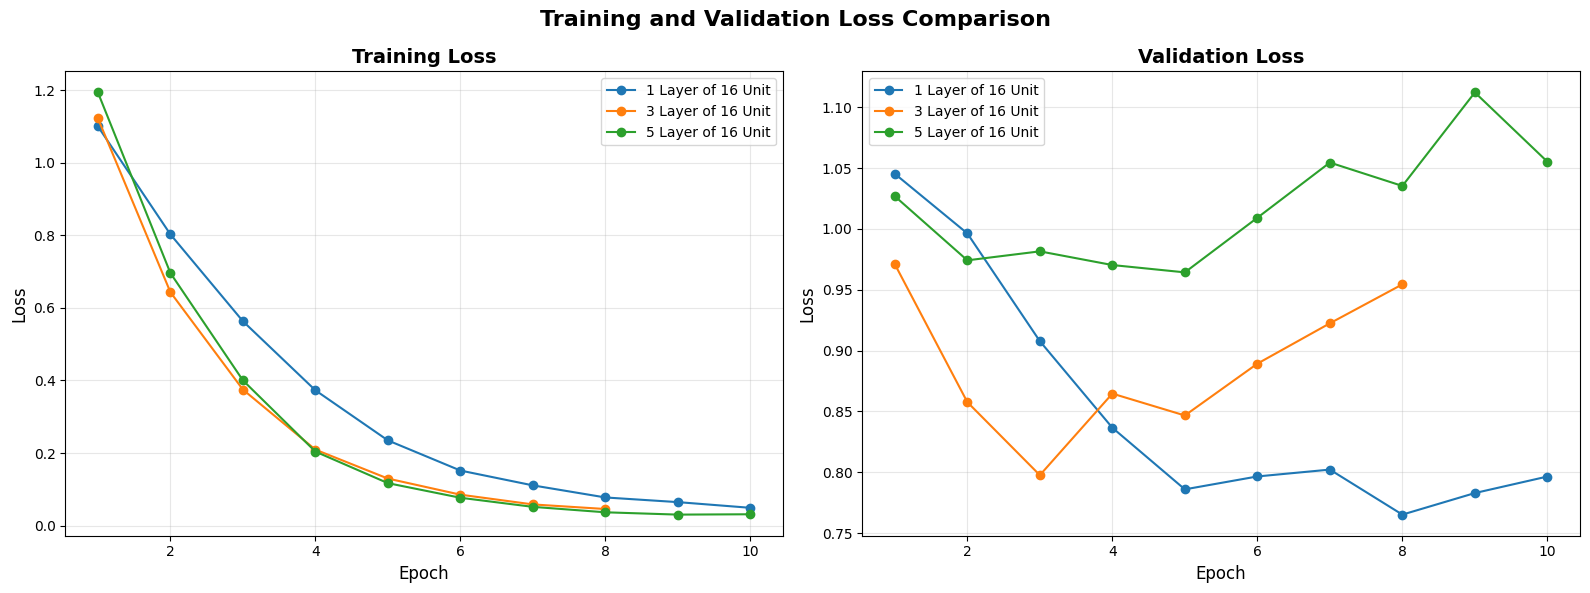

In [478]:
plot_loss_curves(
    history_1_1, 
    history_1_2, 
    history_1_3,
    labels=["1 Layer of 16 Unit", "3 Layer of 16 Unit", "5 Layer of 16 Unit"]
)

## Test 2 : Pengaruh banyak cell RNN

In [489]:
# Model with 2_1 RNN layer
model_2_1 = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Embedding(input_dim=20000, output_dim=128, mask_zero=True),
    Bidirectional(SimpleRNN(16)),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

# Model with 2_2 RNN layers
model_2_2 = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer, 
    Embedding(input_dim=20000, output_dim=128, mask_zero=True),
    Bidirectional(SimpleRNN(64)),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

# Model with 2_3 RNN layers
model_2_3 = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Embedding(input_dim=20000, output_dim=128, mask_zero=True),
    Bidirectional(SimpleRNN(256)),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

In [490]:
model_2_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_2_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_2_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_2_1 = model_2_1.fit(train_ds, validation_data=valid_ds, epochs=10, callbacks=[early_stopping])
history_2_2 = model_2_2.fit(train_ds, validation_data=valid_ds, epochs=10, callbacks=[early_stopping])
history_2_3 = model_2_3.fit(train_ds, validation_data=valid_ds, epochs=10, callbacks=[early_stopping])

y_pred_probs2_1 = model_2_1.predict(test_ds)
y_pred2_1 = np.argmax(y_pred_probs2_1, axis=1)
y_pred_probs2_2 = model_2_2.predict(test_ds)
y_pred2_2 = np.argmax(y_pred_probs2_2, axis=1)
y_pred_probs2_3 = model_2_3.predict(test_ds)
y_pred2_3 = np.argmax(y_pred_probs2_3, axis=1)

# Calculate macro F1-score
f1_macro2_1 = f1_score(y_true, y_pred2_1, average='macro')
f1_macro2_2 = f1_score(y_true, y_pred2_2, average='macro')
f1_macro2_3 = f1_score(y_true, y_pred2_3, average='macro')

print(f"\nMacro F1-Score for Model 2_1: {f1_macro2_1:.4f}")
print(f"Macro F1-Score for Model 2_2: {f1_macro2_2:.4f}")
print(f"Macro F1-Score for Model 2_3: {f1_macro2_3:.4f}")

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.2874 - loss: 1.1436 - val_accuracy: 0.3900 - val_loss: 1.0847
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7940 - loss: 0.8073 - val_accuracy: 0.4700 - val_loss: 1.0420
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9442 - loss: 0.5471 - val_accuracy: 0.4800 - val_loss: 1.0085
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9862 - loss: 0.3459 - val_accuracy: 0.4500 - val_loss: 1.0102
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9994 - loss: 0.2167 - val_accuracy: 0.4600 - val_loss: 1.0302
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 1.0000 - loss: 0.1613 - val_accuracy: 0.4400 - val_loss: 1.0649
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9975 - loss: 0.1029 - val_accuracy: 0.4500 - val_loss: 1.0866
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 1.0000 - loss: 0.0774 - val_accuracy: 0.4300 - 

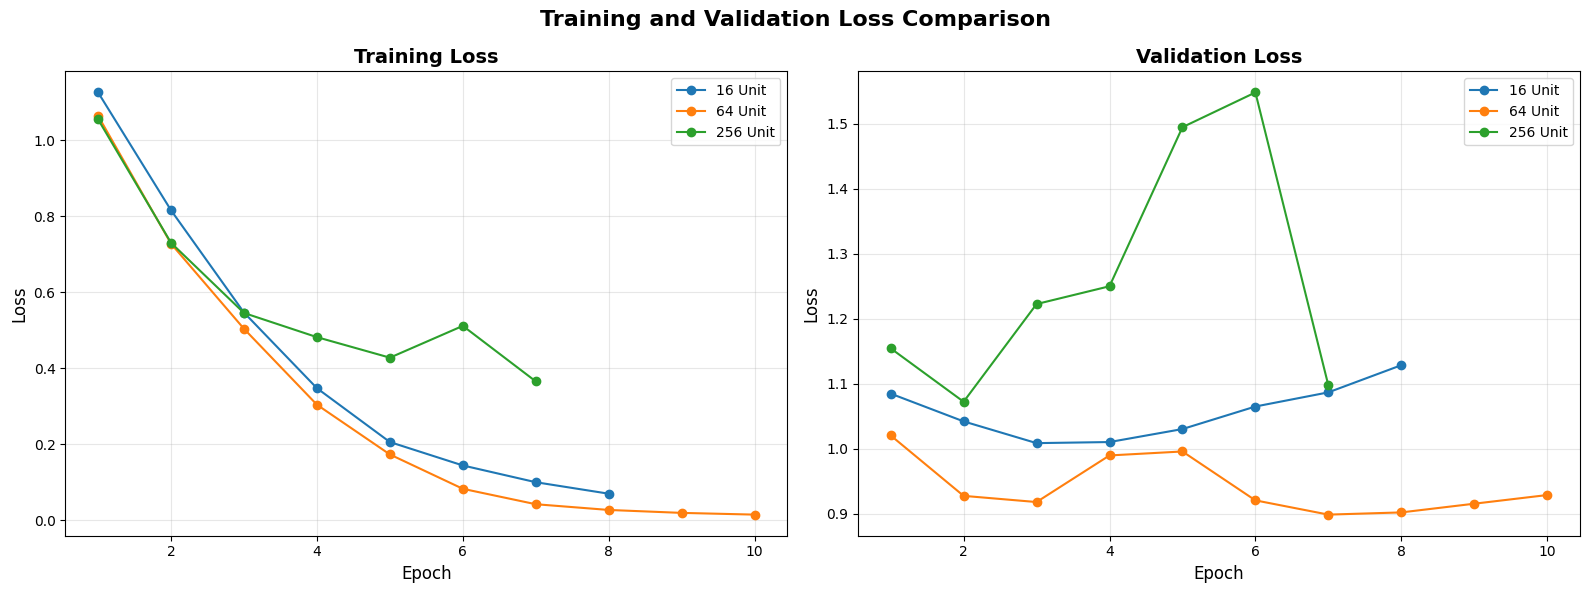

In [492]:
plot_loss_curves(
    history_2_1,
    history_2_2,
    history_2_3,
    labels=["16 Unit", "64 Unit", "256 Unit"]
)

## Test 3 : Pengaruh jenis layer berdasarkan arah

In [484]:
# Model with 3_1 RNN layer
model_3_1 = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Embedding(input_dim=20000, output_dim=128, mask_zero=True),
    Bidirectional(SimpleRNN(16)),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

# Model with 3_2 RNN layers
model_3_2 = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer, 
    Embedding(input_dim=20000, output_dim=128, mask_zero=True),
    SimpleRNN(16),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

In [485]:
model_3_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_3_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_3_1 = model_3_1.fit(train_ds, validation_data=valid_ds, epochs=10, callbacks=[early_stopping])
history_3_2 = model_3_2.fit(train_ds, validation_data=valid_ds, epochs=10, callbacks=[early_stopping])

y_pred_probs3_1 = model_3_1.predict(test_ds)
y_pred3_1 = np.argmax(y_pred_probs3_1, axis=1)
y_pred_probs3_2 = model_3_2.predict(test_ds)
y_pred3_2 = np.argmax(y_pred_probs3_2, axis=1)


# Calculate macro F1-score
f1_macro3_1 = f1_score(y_true, y_pred3_1, average='macro')
f1_macro3_2 = f1_score(y_true, y_pred3_2, average='macro')

print(f"\nMacro F1-Score for Model 3_1: {f1_macro3_1:.4f}")
print(f"Macro F1-Score for Model 3_2: {f1_macro3_2:.4f}")

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.4361 - loss: 1.0737 - val_accuracy: 0.5500 - val_loss: 0.9780
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.7986 - loss: 0.7226 - val_accuracy: 0.6300 - val_loss: 0.8476
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9385 - loss: 0.4705 - val_accuracy: 0.6900 - val_loss: 0.7734
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9728 - loss: 0.3080 - val_accuracy: 0.6700 - val_loss: 0.7527
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9936 - loss: 0.2046 - val_accuracy: 0.6600 - val_loss: 0.7425
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9845 - loss: 0.1673 - val_accuracy: 0.6600 - val_loss: 0.7563
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9994 - loss: 0.1012 - val_accuracy: 0.6400 - val_loss: 0.7851
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0710 - val_accuracy: 0.6500 - 

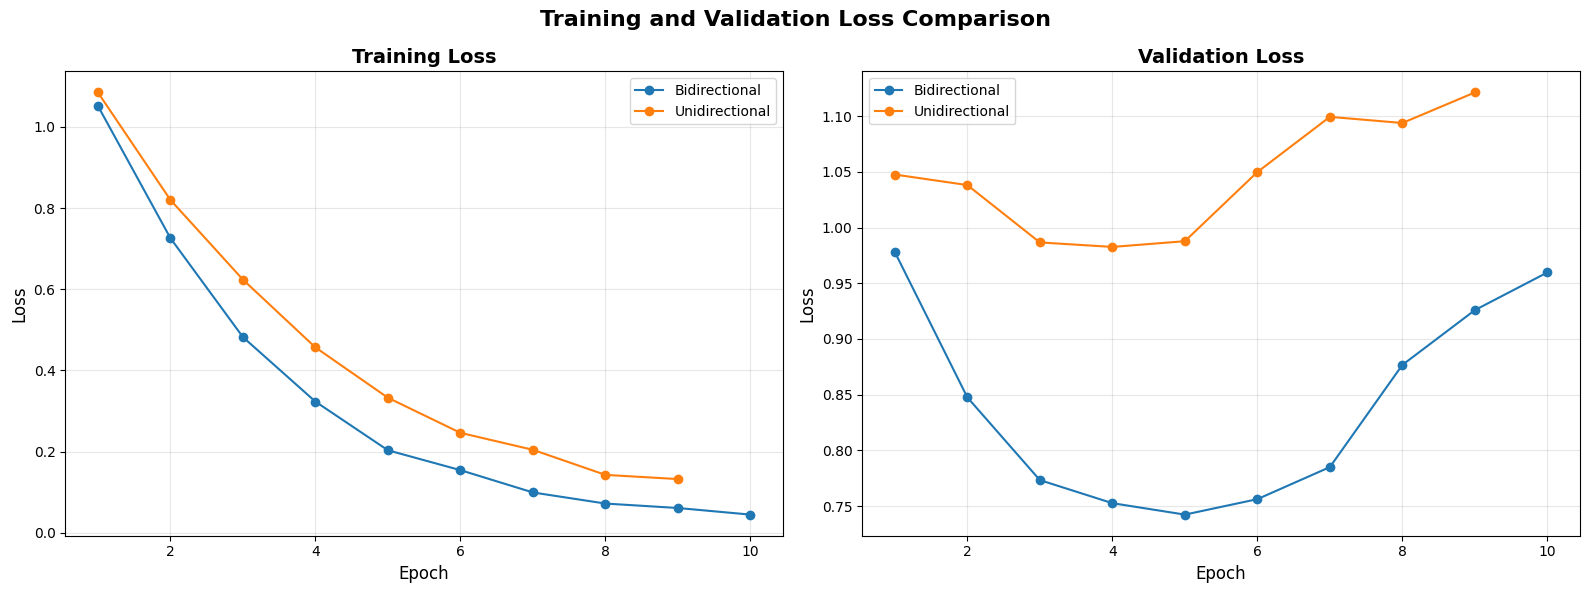

In [491]:
plot_loss_curves(
    history_3_1,
    history_3_2,
    labels=["Bidirectional", "Unidirectional"]
)